In [1]:
push!(LOAD_PATH, "..")
using ASE
# using MatSciPy
using PyPlot
using PyCall
import TightBinding

16

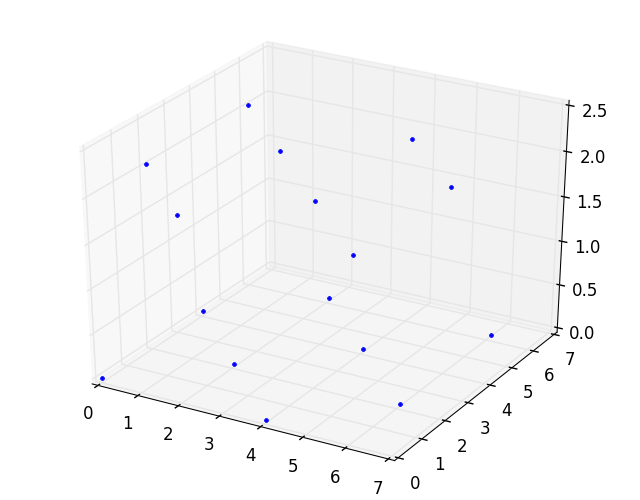

In [2]:
at = bulk("Al"; cubic=true)
at = repeat(at, (2, 2, 1))
X = positions(at)
plot3D(X[1,:][:], X[2,:][:], X[3,:][:], "b.")
print(length(at))

### Test set_eF

In [4]:
reload("Potentials")
reload("tbtoymodel")
reload("TightBinding")
reload("NRLTB")

at = bulk("Al"; cubic=true)
at = repeat(at, (3, 3, 3))
set_pbc!(at, [true, true, true])

tbm = NRLTB.NRLTBModel(elem = NRLTB.Al_spd)
tbm.nkpoints = (4,4,4)

TightBinding.update_eig!(at, tbm)
tbm.fixed_eF = false
TightBinding.update_eF!(at, tbm)
print(tbm.eF)

1.0884528916461678

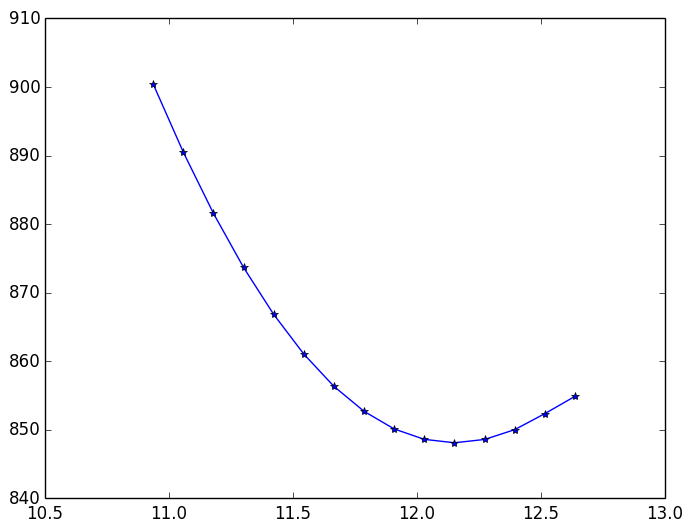

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x120c6890>

In [8]:
# The following computation somehow implies that the NRL model for Al is stable

at = bulk("Al"; cubic=true)
at = repeat(at, (3, 3, 3))
set_pbc!(at, [true, true, true])
X = positions(at)
tbm.nkpoints = (2,2,2)

lc = norm(cell(at)[1,:][:])
x = zeros(15)
e = zeros(15)
for k = -10:4
    rate = 1.0 + 0.01 * k
    Y = X * rate
    set_positions!(at, Y)
    x[k+11] = lc * rate
    e[k+11] = TightBinding.potential_energy(at, tbm)
end
plot(x,e, "*-") 

### Test toy model

In [4]:
reload("Potentials")
reload("tbtoymodel")
reload("TightBinding")
reload("MatSciPy")
tbm = TightBinding.ToyTB.ToyTBModel(r0=2.5, rcut=6.0)
E = TightBinding.potential_energy(at, tbm)
println("E = ", E)
frc = TightBinding.forces(at, tbm)
println("|f|∞ = ", norm(frc[:], Inf))

E = -

15.758671486710963
|f|∞ = 4.614364446098307e-16


In [7]:
set_pbc!(at, [false, false, false])

reload("TightBinding")
tbm = TightBinding.ToyTB.ToyTBModel(r0=2.5, rcut=6.0)
E = TightBinding.potential_energy(at, tbm)
println("E = ", E)
frc = TightBinding.forces(at, tbm)
println("|f|∞ = ", norm(frc[:], Inf))

E = -

2.2402263145143673
|f|∞ = 0.14601367064044007


In [5]:
reload("Potentials")
reload("TightBinding")
reload("tbtoymodel")

set_pbc!(at, [false, false, false])
#set_pbc!(at, [true, true, true])

tbm = TightBinding.ToyTB.ToyTBModel(r0=2.5, rcut=8.0)
X = positions(at)
f = TightBinding.potential_energy(at, tbm)
df = TightBinding.forces(at, tbm)[:]
    println("-----------------------------")
    println("  p | error ")
    println("----|------------------------")
    for p = 2:12
        h = 0.1^p
        dfh = zeros(length(df))
        for n = 1:length(df)
            X[n] += h
            set_positions!(at, X)
            dfh[n] = (TightBinding.potential_energy(at, tbm) - f) / h
            X[n] -= h
        end
    #@printf(" %2d | %1.7e \n", p, norm(df - dfh, Inf))
    @printf(" %2d | %1.7e \n", p, norm(dfh + df, Inf))
    end
println("-----------------------------")


-----------------------------
  p | error 
----|------------------------
  2 | 1.4867346e-03 
  3 | 1.4867270e-04 
  4 | 1.4867263e-05 
  5 | 1.4865886e-06 
  6 | 1.5010215e-07 
  7 | 2.4461734e-08 
  8 | 3.1718760e-07 
  9 | 3.1797765e-06 
 10 | 3.8596093e-05 
 11 | 3.8683979e-04 
 12 | 3.9968029e-03 
-----------------------------


### Test NRL 

In [3]:
# TEST the NRL-TB hamiltonian constructor
import NRLTB
reload("NRLTB")
a = rand(3)*6

f = NRLTB.mat_local(norm(a), a, NRLTB.Al_spd, "H")
df = NRLTB.d_mat_local(norm(a), a, NRLTB.Al_spd, "dH")
println("-----------------------------")
println("  p | error ")
println("----|------------------------")
for p = 2:12
    h = 0.1^p
    dfh = zeros(size(df))
    for n = 1:3
        a[n] += h
        fh = NRLTB.mat_local(norm(a), a, NRLTB.Al_spd, "H")
        dfh[n,:] = (fh - f) / h
        a[n] -= h
    end
    err = reshape(dfh - df, 3*81)
    @printf(" %2d | %1.7e \n", p, norm(err,Inf))
end
println("-----------------------------")

LoadError: LoadError: TypeError: d_mat_local: in typeassert, expected Symbol, got ASCIIString
while loading In[3], in expression starting on line 7

In [7]:
# TEST NRL-TB for Aluminum FCC

reload("SparseTools")
reload("Potentials")
reload("TightBinding")
reload("NRLTB")    
BOHR = 0.52917721092 

set_pbc!(at, [false, false, false])
tbm = NRLTB.NRLTBModel(elem = NRLTB.Al_spd)

X = positions(at)
f = TightBinding.potential_energy(at, tbm)
df = TightBinding.forces(at, tbm)[:] #/ BOHR
    println("-----------------------------")
    println("  p | error ")
    println("----|------------------------")
for p = 2:12
    h = 0.1^p 
    dfh = zeros(length(df))
    for n = 1:length(df)
        X[n] += h
        set_positions!(at, X)
        dfh[n] = (TightBinding.potential_energy(at, tbm) - f) / h
        X[n] -= h
    end
    @printf(" %2d | %1.7e \n", p, norm(dfh + df, Inf))
end
println("-----------------------------")

 | 9.0912505e-02 
-----------------------------
-----------------------------
  p | error 
----|------------------------
  2 | 8.2956353e-04 
  3 | 8.2980625e-05 
  4 | 8.2981779e-06 
  5 | 8.2923689e-07 
  6 | 9.0497308e-08 
  7 | 2.5844245e-07 
  8 | 2.6846495e-06 
  9 | 2.4839610e-05 
 10 | 2.5593135e-04 
 11 | 2.9698982e-03 
 12 | 2.4861879e-02 
-----------------------------


In [24]:
# TEST NRL-TB for Aluminum FCC
# WITH PERIODIC BOUNDARY CONDITION ON THIRD DIMENSION
# TAKE nkpoints = (0,0,4)

reload("SparseTools")
reload("Potentials")
reload("TightBinding")
reload("NRLTB")    
BOHR = 0.52917721092 

set_pbc!(at, [false, false, true])
tbm = NRLTB.NRLTBModel(elem = NRLTB.Al_spd)
tbm.nkpoints = (0,0,4)


X = positions(at)
f = TightBinding.potential_energy(at, tbm)
df = TightBinding.forces(at, tbm)[:] #/ BOHR
    println("-----------------------------")
    println("  p | error ")
    println("----|------------------------")
for p = 2:12
    h = 0.1^p 
    dfh = zeros(length(df))
    for n = 1:length(df)
        X[n] += h
        set_positions!(at, X)
        dfh[n] = (TightBinding.potential_energy(at, tbm) - f) / h
        X[n] -= h
    end
    @printf(" %2d | %1.7e \n", p, norm(dfh + df, Inf))
end
println("-----------------------------")

-----------------------------
  p | error 
----|------------------------
  2 | 1.3856343e-03 
  3 | 1.3857957e-04 
  4 | 1.3857999e-05 
  5 | 1.3862689e-06 
  6 | 1.4210855e-07 
  7 | 9.9173318e-08 
  8 | 7.1054274e-07 
  9 | 8.6132161e-06 
 10 | 7.1054274e-05 
 11 | 7.1054274e-04 
 12 | 5.5803849e-03 
-----------------------------


### pull k-loop into site-loop

In [5]:
reload("SparseTools")
reload("Potentials")
reload("TightBinding")
reload("NRLTB")  

at = bulk("Al"; cubic=true)
at = repeat(at, (3, 3, 1))
set_pbc!(at, [false, false, true])
X = positions(at)
tbm = NRLTB.NRLTBModel(elem = NRLTB.Al_spd)
tbm.nkpoints = (0,0,2)

set_positions!(at, X+0.1*rand(size(X)))
@time F = TightBinding.forces(at, tbm)
@time F = TightBinding.forces_(at, tbm)
println("\n")
set_positions!(at, X+0.1*rand(size(X)))
@time F = TightBinding.forces(at, tbm)
@time F = TightBinding.forces_(at, tbm)
println("\n")
set_positions!(at, X+0.1*rand(size(X)))
@time F = TightBinding.forces(at, tbm)
@time F = TightBinding.forces_(at, tbm)
println("\n")
set_positions!(at, X+0.1*rand(size(X)))
@time F = TightBinding.forces(at, tbm)
@time F = TightBinding.forces_(at, tbm)
println("\n")

  2.655980 seconds (4.52 M allocations: 832.425 MB, 6.00% gc time)
109.995452 seconds (30.89 M allocations: 124.648 GB, 6.25% gc time)


  0.717361 seconds (2.13 M allocations: 738.019 MB, 17.81% gc time)
103.413738 seconds (30.79 M allocations: 124.644 GB, 5.74% gc time)


  0.713252 seconds (2.13 M allocations: 738.894 MB, 18.23% gc time)
100.832930 seconds (30.81 M allocations: 124.719 GB, 5.75% gc time)


  0.728110 seconds (2.13 M allocations: 737.797 MB, 17.38% gc time)
109.745186 seconds (30.78 M allocations: 124.593 GB, 5.48% gc time)




# Performance Tests (CO)

In [1]:
push!(LOAD_PATH, "..")
using ASE, TestAtoms
import TightBinding
import NRLTB
import ProfileView, Base.Profile

In [7]:
at = bulk("Al"; cubic=true)
at = repeat(at, (4, 3, 1))
set_pbc!(at, [false, false, true])
X = positions(at)
tbm = NRLTB.NRLTBModel(elem = NRLTB.Al_spd)
# tbm = TightBinding.ToyTB.ToyTBModel()
tbm.nkpoints = (0,0,1)
# TestAtoms.test_potentialenergy(tbm, at)
set_positions!(at, X+0.1*rand(size(X)))
@time E = TightBinding.potential_energy(at, tbm)
set_positions!(at, X+0.1*rand(size(X)))
@time E = TightBinding.potential_energy(at, tbm)
set_positions!(at, X+0.1*rand(size(X)))
@time E = TightBinding.potential_energy(at, tbm)
set_positions!(at, X+0.1*rand(size(X)))
@time E = TightBinding.potential_energy(at, tbm)

@time df = TightBinding.forces(at, tbm);
@time df = TightBinding.forces(at, tbm);
@time df = TightBinding.forces(at, tbm);
@time df = TightBinding.forces(at, tbm);

# TightBinding.forces_debug(at, tbm)
;

  0.345377 seconds (559.68 k allocations: 324.792 MB, 23.51% gc time)
  0.336431 seconds (559.75 k allocations: 324.824 MB, 22.30% gc time)
  0.352452 seconds (559.68 k allocations: 324.792 MB, 22.07% gc time)
  0.332860 seconds (559.68 k allocations: 324.792 MB, 24.41% gc time)
  0.308003 seconds (1.24 M allocations: 290.920 MB, 11.97% gc time)
  0.280479 seconds (1.24 M allocations: 290.920 MB, 8.55% gc time)
  0.285993 seconds (1.24 M allocations: 290.920 MB, 7.39% gc time)
  0.336620 seconds (1.24 M allocations: 290.920 MB, 22.21% gc time)


In [12]:
@code_warntype TightBinding.hamiltonian(at, tbm, rand(3))

In [3]:


at = bulk("Al"; cubic=true)
at = repeat(at, (4, 4, 1))
X = positions(at)
set_pbc!(at, [false, false, true])
tbm = NRLTB.NRLTBModel(elem = NRLTB.Al_spd)
# tbm = TightBinding.ToyTB.ToyTBModel()
tbm.nkpoints = (0,0,4)

Profile.clear()
@profile f = TightBinding.potential_energy(at, tbm);
set_positions!(at, X+0.1*rand(size(X)))
@profile f = TightBinding.potential_energy(at, tbm);


In [13]:
ProfileView.view()